## 1. MLP

page 61

In [1]:
import sys
sys.path.append("../gluon-tutorials-zh")
import gluonbook as gb
from mxnet import gluon, init, nd
from mxnet.gluon import loss as gloss, nn

%matplotlib inline

/Users/i058959/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def xyplot(x_vals, y_vals, x_label, y_label):
    %config InlineBackend.figure_format = "retina"
    gb.plt.rcParams['figure.figsize'] = (3.5, 2.5)
    gb.plt.plot(x_vals, y_vals)
    gb.plt.xlabel(x_label)
    gb.plt.ylabel(y_label)

In [3]:
x = nd.arange(-5.0, 5.0, 0.1)

### Relu

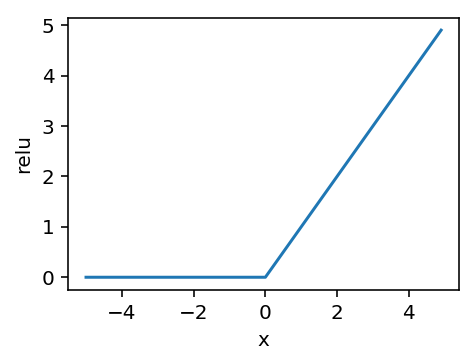

In [4]:
xyplot(x.asnumpy(), x.relu().asnumpy(), 'x', 'relu')

### Sigmoid

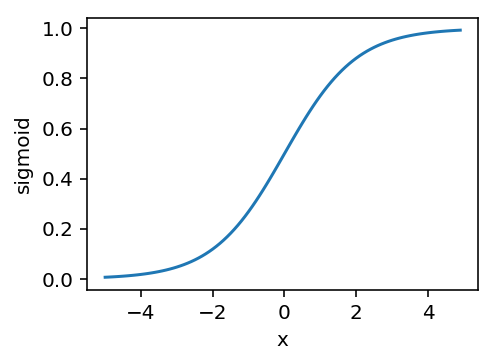

In [5]:
xyplot(x.asnumpy(), x.sigmoid().asnumpy(), 'x', 'sigmoid')

### Tanh

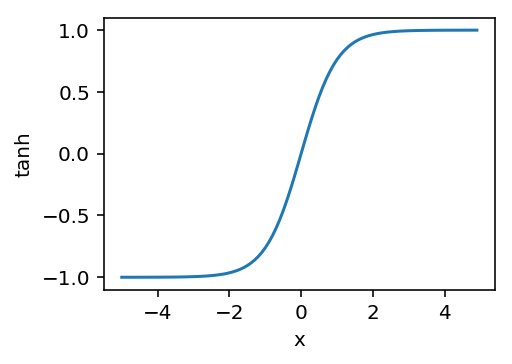

In [6]:
xyplot(x.asnumpy(), x.tanh().asnumpy(), 'x', 'tanh')

## 2. Manual MLP

page 68

In [7]:
from mxnet.gluon import loss as gloss

In [8]:
batch_size = 256
train_iter, test_iter = gb.load_data_fashion_mnist(batch_size)

In [9]:
num_inputs = 784
num_ouputs = 10
num_hiddens = 256

W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens))
b1 = nd.zeros(num_hiddens)
W2 = nd.random.normal(scale=0.01, shape=(num_hiddens, num_ouputs))
b2 = nd.zeros(num_ouputs)
params = [W1, b1, W2, b2]
for param in params:
    param.attach_grad()

In [10]:
def relu(X):
    """
    manually for max(X, 0)
    """
    return nd.maximum(X, 0)

In [11]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(nd.dot(X, W1) + b1)
    return nd.dot(H, W2) + b2

In [12]:
loss = gloss.SoftmaxCrossEntropyLoss()
num_epochs = 5
lr = 0.5
gb.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.8198, train acc 0.694, test acc 0.827
epoch 2, loss 0.4961, train acc 0.814, test acc 0.848
epoch 3, loss 0.4323, train acc 0.841, test acc 0.855
epoch 4, loss 0.4007, train acc 0.852, test acc 0.858
epoch 5, loss 0.3751, train acc 0.860, test acc 0.871


## 3.  Gluon MLP

page 71

In [13]:
from mxnet import gluon, init
from mxnet.gluon import loss as gloass, nn

In [14]:
net = nn.Sequential()
net.add(nn.Dense(num_hiddens, activation='relu'))
net.add(nn.Dense(num_ouputs))
net.initialize(init.Normal(sigma=0.01))

In [15]:
batch_size = 256
train_iter, test_iter = gb.load_data_fashion_mnist(batch_size)
loss = gloss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5})
num_epochs = 5
gb.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 2.3036, train acc 0.076, test acc 0.074
epoch 2, loss 2.3036, train acc 0.076, test acc 0.074
epoch 3, loss 2.3036, train acc 0.076, test acc 0.074
epoch 4, loss 2.3036, train acc 0.076, test acc 0.074
epoch 5, loss 2.3036, train acc 0.076, test acc 0.074


## 4. Overfitting, underfitting and Model Selection

### 4.1 Poloynomial fitting experiment

In [16]:
import sys
sys.path.append("../gluon-tutorials-zh")
import gluonbook as gb
from mxnet import autograd, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

%matplotlib inline

In [17]:
n_train = 100
n_test = 100
true_w = [1.2, -3.4, 5.6]
true_b = 5

features = nd.random.normal(shape=(n_train + n_test, 1))
poly_features = nd.concat(features, nd.power(features, 2), nd.power(features, 3))
labels = (true_w[0] * poly_features[:,0] + true_w[1] * poly_features[:,1] + true_w[2] * poly_features[:,2] + true_b)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

In [18]:
def semilog(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, 
            legend=None, figsize=(3.5, 2.5)):
    gb.set_figsize(figsize)
    gb.plt.xlabel(x_label)
    gb.plt.ylabel(y_label)
    gb.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        gb.plt.semilogy(x2_vals, y2_vals, linestyle=":")
        gb.plt.legend(legend)

In [19]:
num_epochs = 100
loss = gloass.L2Loss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features), test_labels).mean().asscalar())
    print("final epoch: train loss", train_ls[-1], 'test loss', test_ls[-1])
    semilog(range(1, num_epochs+1), train_ls, 'epochs', 'loss', 
            range(1, num_epochs+1), test_ls, ['train', 'test'])
    return ('weight:', net[0].weight.data(), 'loss', net[0].bias.data())

final epoch: train loss 0.010067203 test loss 0.017209608


('weight:', 
 [[ 1.0266504 -3.3127675  5.647937 ]]
 <NDArray 1x3 @cpu(0)>, 'loss', 
 [4.8935604]
 <NDArray 1 @cpu(0)>)

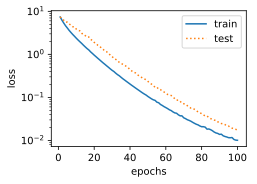

In [20]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

In [21]:
n_train = 100
n_test = 100
true_w = [1.2, -3.4, 5.6]
true_b = 5

features = nd.random.normal(shape=(n_train + n_test, 1))
poly_features = nd.concat(features, nd.power(features, 2), nd.power(features, 3))
labels = (true_w[0] * poly_features[:,0] + true_w[1] * poly_features[:,1] + true_w[2] * poly_features[:,2] + true_b)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

final epoch: train loss nan test loss nan


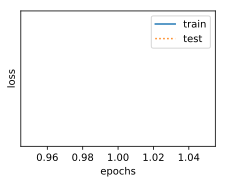

In [22]:
# https://blog.csdn.net/u010824081/article/details/78360476
def linreg(X, w, b): 
    return nd.dot(X, nd.repeat(w, repeats=X.shape[1])) + b

def sgd(params, lr, batch_size): 
    for i, param in enumerate(params):
        param[:] = param - lr * param.grad.mean() / batch_size

# using single w for simulating linear relationship for different feature inputs
w = nd.random.normal(scale=0.01, shape=(1, 1))
b = nd.zeros(shape=(1,))
params = [w, b]
for param in params:
    param.attach_grad()
net = linreg

train_features=poly_features[:n_train, :]; test_features=poly_features[n_train:, :]; train_labels=labels[:n_train]; test_labels=labels[n_train:]

batch_size = min(10, train_labels.shape[0])
train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
train_ls, test_ls = [], []
for _ in range(num_epochs):
    for X, y in train_iter:
        with autograd.record():
            l = loss(net(X, w, b), y)
        l.backward()
        sgd([w, b], lr, batch_size)
    train_ls.append(loss(net(train_features, w, b), train_labels).mean().asscalar())
    test_ls.append(loss(net(test_features, w, b), test_labels).mean().asscalar())
print("final epoch: train loss", train_ls[-1], 'test loss', test_ls[-1])
semilog(range(1, num_epochs+1), train_ls, 'epochs', 'loss', 
        range(1, num_epochs+1), test_ls, ['train', 'test'])

In [23]:
n_train = 100
n_test = 100
true_w = [1.2, -3.4, 5.6]
true_b = 5

features = nd.random.normal(shape=(n_train + n_test, 1))
poly_features = nd.concat(features, nd.power(features, 2), nd.power(features, 3))
labels = (true_w[0] * poly_features[:,0] + true_w[1] * poly_features[:,1] + true_w[2] * poly_features[:,2] + true_b)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

final epoch: train loss 8.455938e-06 test loss 8.98363


('weight:', 
 [[ 2.0621903 -1.2865478  5.49603  ]]
 <NDArray 1x3 @cpu(0)>, 'loss', 
 [-0.29339486]
 <NDArray 1 @cpu(0)>)

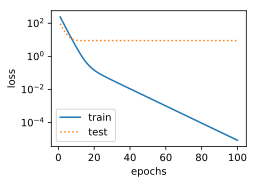

In [24]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2], labels[n_train:])

### 4.2 Linear regression for high dimension data

#### 4.2.1 Weight decay via Manual Implementation
page 81

In [25]:
import sys
sys.path.append("../gluon-tutorials-zh")
import gluonbook as gb
from mxnet import autograd, gluon, nd, init
from mxnet.gluon import data as gdata, loss as gloss, nn

%matplotlib inline

In [26]:
n_train = 20
n_test = 100
num_inputs = 200
true_w = nd.ones((num_inputs, 1)) * 0.01
true_b = 0.05

features = nd.random.normal(shape=(n_train + n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [27]:
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    for param in [w, b]:
        param.attach_grad()
    return [w, b]

In [28]:
def l2_penalty(w):
    return (w**2).sum() / 2

In [29]:
batch_size = 1
num_epochs = 100
lr = 0.003
train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
net = gb.linreg
loss = gb.squared_loss

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls = []
    test_ls = []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                # for adding L2
                l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l.backward()
            gb.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().asscalar())
    gb.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss', range(1, num_epochs+1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().asscalar())

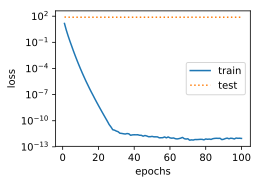

L2 norm of w: 13.043157


In [30]:
# obvious overfitting
fit_and_plot(lambd=0)

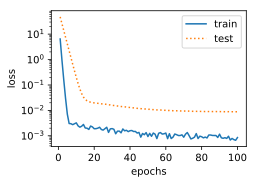

L2 norm of w: 0.034218356


In [31]:
# L2 norm to using weights decay
fit_and_plot(lambd=5)

#### 4.2.2 Weight decay via Gluon
page 90

In [32]:
import sys
sys.path.append("../gluon-tutorials-zh")
import gluonbook as gb
from mxnet import autograd, gluon, nd, init
from mxnet.gluon import data as gdata, loss as gloss, nn

%matplotlib inline

In [33]:
def fit_and_plot_gluon(weight_decay):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    # for weight L2 nromalization
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd', {
        'learning_rate': lr,
        'wd': weight_decay
    })
    # not L2 normalization for bias
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd', {
        'learning_rate': lr
    })
    train_ls = []
    test_ls = []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            # for 2 trainer using step()
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_ls.append(loss(net(train_features), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features), test_labels).mean().asscalar())
    gb.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss', range(1, num_epochs+1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())

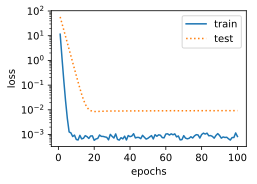

L2 norm of w: 0.033169843


In [34]:
fit_and_plot_gluon(5)

### 4.3 Dropout

#### 4.3.1 Droput via Manual Implementation
page 94

In [35]:
import sys
sys.path.append("../gluon-tutorials-zh")
import gluonbook as gb
from mxnet import autograd, gluon, nd, init
from mxnet.gluon import data as gdata, loss as gloss, nn

%matplotlib inline

In [36]:
def dropout(X, drop_prob):
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    # dropout all of elements under this case
    if keep_prob == 0:
        return X.zeros_like()
    mask = nd.random.uniform(0, 1, X.shape) < keep_prob
    return mask * X / keep_prob

In [37]:
X = nd.arange(16).reshape((2, 8))
dropout(X, 0)


[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]]
<NDArray 2x8 @cpu(0)>

In [38]:
dropout(X, 0.5)


[[ 0.  2.  0.  6.  0.  0.  0. 14.]
 [16. 18. 20.  0. 24. 26. 28.  0.]]
<NDArray 2x8 @cpu(0)>

In [39]:
dropout(X, 1)


[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
<NDArray 2x8 @cpu(0)>

In [40]:
num_inputs = 784
num_outputs = 10
num_hiddens1 = 256
num_hiddens2 = 256
W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens1))
b1 = nd.zeros(num_hiddens1)
W2 = nd.random.normal(scale=0.01, shape=(num_hiddens1, num_hiddens2))
b2 = nd.zeros(num_hiddens2)
W3 = nd.random.normal(scale=0.01, shape=(num_hiddens2, num_outputs))
b3 = nd.zeros(num_outputs)
params = [W1, b1, W2, b2, W3, b3]
for param in params:
    param.attach_grad()

In [43]:
drop_prob1 = 0.2
drop_prob2 = 0.5

def net(X):
    X = X.reshape((-1, num_inputs))
    H1 = (nd.dot(X, W1) + b1).relu()
    # only using dropout in training phase
    if autograd.is_training():
        # add dropout after 1st layer
        H1 = dropout(H1, drop_prob1)
    H2 = (nd.dot(H1, W2) + b2).relu()
    if autograd.is_training():
        # add dropout after 1st layer
        H2 = dropout(H2, drop_prob2)
    return nd.dot(H2, W3) + b3

In [44]:
num_epochs = 5
lr = 0.5
batch_size = 256
loss = gloss.SoftmaxCrossEntropyLoss()
train_iter, test_iter = gb.load_data_fashion_mnist(batch_size)
gb.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 1.1263, train acc 0.558, test acc 0.760
epoch 2, loss 0.5831, train acc 0.782, test acc 0.836
epoch 3, loss 0.4928, train acc 0.821, test acc 0.849
epoch 4, loss 0.4517, train acc 0.835, test acc 0.852
epoch 5, loss 0.4192, train acc 0.848, test acc 0.858


#### 4.3.2 Droput via Gluon
page 97

In [45]:
net = nn.Sequential()
net.add(nn.Dense(256, activation="relu"),
# 在第一个全连接层后添加丢弃层。 
nn.Dropout(drop_prob1), nn.Dense(256, activation="relu"), 
# 在第二个全连接层后添加丢弃层。 
nn.Dropout(drop_prob2), nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

In [46]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
gb.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, trainer)

epoch 1, loss 1.1445, train acc 0.558, test acc 0.784
epoch 2, loss 0.5859, train acc 0.780, test acc 0.832
epoch 3, loss 0.4925, train acc 0.821, test acc 0.824
epoch 4, loss 0.4517, train acc 0.835, test acc 0.860
epoch 5, loss 0.4170, train acc 0.847, test acc 0.862
